# Empirical Analysis of Early Stopping and Learning Rate Scheduling for Deep Learning on Resource-Constrained Hardware

This file serves as the codebase for doing the experimentations done in the paper entitled as ***"Empirical Analysis of Early Stopping and Learning Rate Scheduling for Deep Learning on Resource-Constrained Hardware"***.

This specific file serves as the GPU testing notebook, separating it from the ~~[Colab](./colab.ipynb) and~~ [CPU](./cpu.ipynb) experimentation notebooks.

**Purpose:**

To provide an empirical analysis on how specific training optimizations perform under resource-constrained hardwares. This explores consumer-grade hardware typically accessible to students and researchers with limited resources, allowing a large part of the Deep Learning community to be able to run potentially more complex tasks on such readily available devices.

## Imports

All needed libraries will be imported here.

Unless conditional, all imports must be done in this section to prevent workspace cluttering. Imports are sorted in an ascending manner, starting from "a" to "Z".

In [163]:
from collections import deque
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Any, Dict, Union
import datetime
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import psutil
import random
import seaborn as sns
import subprocess as sp
import tensorflow as tf
import threading
import time

try:
    import GPUtil
    gputil_exist = True
except ImportError:
    gputil_exist = False

if (os.name == 'nt'):
    import winsound

%matplotlib inline

## Data and Variables

Sets all the global data and variables here.

Global variables will be defined and instantiated in this section, preventing a confusing clutter down the line and allowing readability when revisions are needed.

### Instantiations

Instantiations of objects will be done here, preventing mixture of variable preview and definition.

#### Variables

Variable instantiations

##### Dataset and Model Variables

All dataset and model related variables are defined here, separated from the logger related ones, allowing cohesion in the already chaotic ~~world~~ notebook.

In [164]:

data = {
    'class_names': [
		'airplane', 'automobile', 'bird', 'cat', 'deer',
		'dog', 'frog', 'horse', 'ship', 'truck'
    ],
	'train': {
		'x': None,
		'y': None,
	},
	'test': {
		'x': None,
		'y': None,
	},
    'val': None,
}
(data['train']['x'], data['train']['y']), (data['test']['x'], data['test']['y']) = tf.keras.datasets.cifar10.load_data()

callbacks = [
    # EarlyStopping(
    #     monitor = 'val_loss',
    #     patience = 10,
    #     verbose = 2,
    #     restore_best_weights = True
    # ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 5,
        verbose = 2,
        min_lr = 1e-6
    )
]

save_plots = True

None

##### Metrics related variables

(Static) Variables that will be used by the metric logger. Some variables are localized to the country where the researcher is based.

When recreating the experiment, feel free to modify the values of the following variables to match your location's costs:

- `local_currency_name`: The name of your local currency *(i.e.: Philippine Peso -> `"peso"`)*
- `to_usd_conversion`: The cost of your location's currency to USD.
- `cost_per_kwh_local`: The killowatt/hour cost in your location. Use local currency values.

Some other variables are also changeable to allow the researcher(s) to easily update their values such as the `cpu_tdp`:

- `platform`: The platform on where the experiment was done. In the researcher's case, it is `"RTX 3050 Ti Laptop"`.
- `cpu_tdp`: The CPU's themal design power (TDP) in watts. This is different for every CPU.
- `room_temp`: The current room temperature of where the hardware is located while the experiment is being conducted.

These last two variables are for the logging:

- `prefix`: The location on where the log will be saved. Could be a relative or an absolute path.
- `file_name`: The name of the log file. Must be a JSON format... but realistically, it could be any file extension. In the end, it'll still log it in JSON. ~~LMAO~~

In [165]:
# The local currency used by the researcher (PHP -> peso)
local_currency_name = "peso"
"""
Defines the name of the local currency used by the researcher. This is to simplify
and allow flexible changes to the local currency when someone wishes to recreate the
experiment in a different country or region.
"""

# As of May 30, 2025 (PHP -> USD)
to_usd_conversion = 0.018
"""
Defines the conversion rate of the local currency to US Dollar.
"""

# kwh in local currency (in this case, PHP)
cost_per_kwh_local = 13.01
"""
A fixed cost per kilowatt-hour in the local currency; the currency used by the country where
the researcher is based.
"""

# kwh in US Dollar
cost_per_kwh_usd = cost_per_kwh_local * to_usd_conversion
"""
A dollar conversion of the cost per kilowatt-hour from the local currency.
"""

platform = "RTX 3050 Ti Laptop"
"""
Defines the platform used for the experiment.
"""

cpu_tdp = 45
"""
Defines the thermal design power (TDP) of the CPU in watts.
"""

env_temp = 32.3
"""
Manual temperature setting for the time the experiment was conducted. The researcher used the
location's temperature based on the weather station at the time of the experiment. However,
it would be better to use a temperature sensor to get the temperature of the room where the
experiment was conducted for a more accurate result.

Temperature is in degrees Celsius.
"""

prefix = "./../out/gpu"
"""
Defines the output directory for the training metrics.
"""

file_name = lambda postfix=None: f"{prefix}/training_metrics{f'-{postfix}' if postfix is not None and len(postfix) > 0 else ''}.log"
"""
Defines the file name for the training metrics.
"""

file_postfix = f"{platform.replace(' ', '_')}"
"""
A postfix for the output files to differentiate between different runs or experiments.
This can be used to append a unique identifier or timestamp to the file name.
"""

run_number = 2
"""
Defines the current run's iteration number. This is useful for tracking multiple runs
or experiments, allowing the researcher to differentiate between them.

This can be incremented for each new run to ensure that the output files do not
overwrite each other.
"""

for strat in callbacks:
    file_postfix += f"-{strat.__class__.__name__}"
file_postfix += f"-run_{run_number}"
    
None

#### Functions

Function creation

##### Helper Functions

In [166]:
def showImg(input, title = None, axis = False):
    """
    Displays an image.

    :param input: The image to display.
    :type input: numpy.ndarray
    
    :param title: Title of the image.
    :type title: str

    :param axis: Whether to show the axis or not.
    :type axis: bool
    """
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    if not axis:
        plt.axis('off')
    plt.show()

def get_optimal_workers(batch_size = 32, has_augmentation = True, conservative = False, verbose = True, use = "recommended"):
    """
    Determine optimal number of workers for model.fit() based on system specs and use case.

    :param batch_size: The batch size used for training. (Default: 32)
    :type batch_size: int

    :param has_augmentation: Whether the training process involves data augmentation. (Default: True)
    :type has_augmentation: bool

    :param conservative: Whether to use a conservative estimate for the number of workers. (Default: False)
    :type conservative: bool

    :param verbose: Whether to print recommendations and system info. (Default: True)
    :type verbose: bool

    :param use: The type of recommendation to use. Values are "recommended", "current_default", "conservative", "aggressive", or "ask". (Default: "recommended")
    :type use: str

    :return: Recommended number of workers.
    :rtype: int

    :raises ValueError: If `batch_size` is not a positive integer. Or if `use` is not one of the expected values.
    """
    if not isinstance(batch_size, int) or batch_size <= 0:
        raise ValueError("batch_size must be a positive integer")

    if use not in ["recommended", "current_default", "conservative", "aggressive", "ask"]:
        raise ValueError("use must be one of: 'recommended', 'current_default', 'conservative', 'aggressive', or 'ask'")
    
    # Get system info
    # Includes hyperthreading
    logical_cores = psutil.cpu_count(logical = True)
    # Actual CPU cores
    physical_cores = psutil.cpu_count(logical = False)
    available_memory_gb = psutil.virtual_memory().total / (1024**3)
    
    if verbose:
        print(f"System: {physical_cores} physical cores, {logical_cores} logical cores, {available_memory_gb:.1f}GB RAM")
    
    # If conservative mode, leave one core for the system
    if conservative:
        recommended = max(1, physical_cores - 1)
        reason = "Conservative (leaves 1 core for system)"
    # If using GPU, adjust based on GPU memory
    elif has_augmentation:
        if batch_size <= 32:
            recommended = physical_cores
            reason = "I/O-bound augmentation with small batches"
        elif batch_size <= 128:
            recommended = min(logical_cores, physical_cores + 2)
            reason = "I/O-bound augmentation with medium batches"
        else:
            recommended = logical_cores
            reason = "I/O-bound augmentation with large batches"
    # If not using augmentation, adjust based on batch size
    else:
        if batch_size <= 64:
            recommended = max(1, physical_cores // 2)
            reason = "CPU-bound without augmentation"
        else:
            recommended = physical_cores
            reason = "CPU-bound without augmentation, large batches"
    
    # Memory constraint check (assume ~200MB per worker)
    memory_limit = max(1, int(available_memory_gb * 1024 / 200))
    if recommended > memory_limit:
        recommended = memory_limit
        reason += f" (limited by {available_memory_gb:.1f}GB RAM)"
    
    # Cap at reasonable maximum to prevent overhead
    recommended = min(recommended, 16)

    alts = {
        "Current default": multiprocessing.cpu_count(),
        "Conservative": max(1, physical_cores - 1),
        "Aggressive": logical_cores,
        "Recommended": recommended
    }

    alt_keys = {}
    index = 0
    for key in alts.keys():
        index += 1
        alt_keys[index] = key
    
    if verbose:
        print(f"Recommended workers: {recommended} ({reason})")
        
        # Show alternatives
        print("Alternatives to test:")
        for name, count in alts.items():
            if count != recommended:
                print(f"  {name}: {count} workers")

    use = use.lower().strip().replace(" ", "_")

    if use == "current_default":
        to_return = alts["Current default"]
    elif use == "conservative":
        to_return = alts["Conservative"]
    elif use == "aggressive":
        to_return = alts["Aggressive"]
    elif use == "ask" and verbose:
        while True:
            print("\nChoose a recommendation:")
            for index, key in alt_keys.items():
                print(f"  [{index}] {key}")
            choice = input("Enter the number of your choice: ").strip()

            if choice.isdigit() and int(choice) in alt_keys:
                to_return = alts[alt_keys[int(choice)]]
                break
            else:
                print("Invalid choice, please try again.")
    else:
        to_return = recommended
        
    return to_return

None

##### Logger Related Functions

The `log_metrics` function logs all the needed metrics for the run. This includes CPU, GPU, and training metrics. The list below will explain all log keys in detail (aside from training metric keys).

**Training Metrics**
- `epoch`: The epoch in which the metrics were recorded.
- `loss`: The loss value at the end of the epoch.
- `accuracy`: The accuracy value at the end of the epoch.
- `val_loss`: The validation loss value at the end of the epoch.
- `val_accuracy`: The validation accuracy value at the end of the epoch.
- `training_time_hours`: The total training time of the model.
- `platform`: The platform in which the training is counducted (i.e., Intel i5, RTX 3050 Ti, Colab, ...)
- `lr_strategy`: The learning rate strategy. Not really limited to learning rate and in this case, it could be the `EarlyStopping`, `ReduceLROnPlateau`, `None`, or `EarlyStopping-ReduceLROnPlateau`.
- `env_temp`: Defines the environment (ambiance) temperature. A hardocded one must be provided (in the variable section) but if there's an API key from [WeatherAPI](weatherapi.com) is provided, then it fetches the `location`'s temperature every epoch end.
- `timestamp`: The datetime when the epoch ended and recorded.

**CPU Metrics**
- `cpu_percent_peak`: The peak CPU usage throughout the entire epoch.
- `cpu_percent`: Defines the average CPU usage for the entire epoch. The CPU usage also includes other running tasks and applications as isolating the usage of the training alone is practically impossible.
- `cpu_power`: The power consumption of the CPU. This is calculated based on the provided `cpu_percent` using this formula: `(cpu_percent / 100) * cpu_tdp`.

**GPU Metrics**
- `gpu_load`: The GPU's average load (in percentage) throughout the entire epoch.
- `gpu_load_peak`: The peak GPU load (in percentage) throughout the entire epoch.
- `gpu_power`: The GPU's average power consumption (in watts). This is directly drawn using the `nvidia-smi` command.
- `gpu_power_peak`: The peak GPU power consumption (in watts) during training. Similarly, it is also directly drawn using the `nvidia-smi` command.
- `gpu_temp`: The GPU temperature (in Celsius) during training (if available). This is directly drawn using the `nvidia-smi` command.
- `gpu_temp_peak`: The peak GPU temperature (in Celsius) during training (if available). Similarly, it is also directly drawn using the `nvidia-smi` command.

**Efficiency Metrics**
The `cost_local` defines the tester's current local currency. From that, the `cost_usd` is derived using `cost_local / to_usd_conversion`.

- `cost_efficiency_local`: The cost efficiency in the local currency (calculated based on accuracy and cost). To be precise, it is calculated using the formula `(accuracy * 100) / cost_local`.
- `cost_per_accuracy_point_local`: The cost per accuracy point in the local currency (calculated based on accuracy and cost). To be precise, it is calculated using the formula `cost_local / (accuracy * 100)`.
- `cost_efficiency_usd`: The cost efficiency in US dollars (calculated based on accuracy and cost). To be precise, it is calculated using the formula `(accuracy * 100) / cost_usd`.
- `cost_per_accuracy_point_usd`: The cost per accuracy point in US dollars (calculated based on accuracy and cost). To be precise, it is calculated using the formula `cost_usd / (accuracy * 100)`.
- `power_efficiency`: The accuracy % per watt. Higher values shows more efficient power usage whereas lower ones are the opposite.
- `time_efficiency`: The accuracy % per hour. Higher values shows more efficient power usage whereas lower ones are the opposite.

Both the `cost_efficiency_local` and `cost_efficiency_usd` uses accuracy % per cost. Higher cost efficiency means better.

On the other hand, `cost_per_accuracy_point_local` and `cost_per_accuracy_point_usd` uses cost per 1% accuracy; a direct opposite of the former.

In [167]:
def log_metrics(metrics: Dict[str, Any], platform: str, lr_strategy: str, callback_instance: Union[Callback, None] = None):
    """
    Logs the training metrics to a JSON file, including the platform (manual input) and
    learning rate strategy (manual input). Some metrics are fixed and are defined in the
    global variables section (under `Metrics related variables`).

    The metrics that are logged include:
    - `epoch`: The epoch in which the metrics were recorded.
    - `loss`: The loss value at the end of the epoch.
    - `accuracy`: The accuracy value at the end of the epoch.
    - `val_loss`: The validation loss value at the end of the epoch.
    - `val_accuracy`: The validation accuracy value at the end of the epoch.
    - `training_time_hours`: The total training time in hours.
    - `platform`: The platform on which the training was performed (manual input).
    - `lr_strategy`: The learning rate strategy used during training (manual input).
    - `env_temp`: The room temperature during training (under `Metrics related variables`).
    - `cpu_percent_peak`: The peak CPU usage (in percentage) during training.
    - `cpu_percent`: The CPU usage (in percentage) during training.
    - `cpu_power`: The CPU power consumption (in watts) during training.
    - `gpu_load`: The GPU load (in percentage) during training.
    - `gpu_load_peak`: The peak GPU load (in percentage) during training.
    - `gpu_power`: The GPU power consumption (in watts) during training.
    - `gpu_power_peak`: The peak GPU power consumption (in watts) during training.
    - `gpu_temp`: The GPU temperature during training (if available).
    - `gpu_temp_peak`: The peak GPU temperature during training (if available).
    - `cost_efficiency_local`: The cost efficiency in the local currency (calculated based on accuracy and cost).
    - `cost_per_accuracy_point_local`: The cost per accuracy point in the local currency (calculated based on accuracy and cost).
    - `cost_efficiency_usd`: The cost efficiency in US dollars (calculated based on accuracy and cost).
    - `cost_per_accuracy_point_usd`: The cost per accuracy point in US dollars (calculated based on accuracy and cost).
    - `power_efficiency`: The efficiency in terms of accuracy per watt.
    - `time_efficiency`: The efficiency in terms of accuracy per hour.
    - `timestamp`: The timestamp when the metrics were logged.

    **NOTE:** The `..._local_currency` refers to the local currency used by the researcher, which is defined in the global variables section.
    This may be changed to a different currency to reflect the local currency of the researcher.
    In the original experiment, the local currency is the Philippine peso (PHP). The variable is named `cost_per_kwh_local` so that it is easy
    to understand that this could be changed easily into other local currency anyone wishes to use.

    :param metrics: The training metrics to log.
    :type metrics: dict

    :param platform: The platform on which the training was performed.
    :type platform: str

    :param lr_strategy: The learning rate strategy used during training.
    :type lr_strategy: str

    :param callback_instance: The callback instance that triggered the logging, if any.
    :type callback_instance: tensorflow.keras.callbacks.Callback or None
    """
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    # Add new fields to the metrics dictionary
    metrics['platform'] = platform
    metrics['lr_strategy'] = lr_strategy
    
    # Get the location's temperature
    metrics['env_temp'] = get_env_temp()

    get_cpu_metrics(metrics, callback_instance)
    get_gpu_metrics(metrics, callback_instance)

    # Other metrics
    effective_power = {
        "cpu": metrics.get("cpu_power", 0),
        "gpu": metrics.get("gpu_power", 0)
    }

    if type(effective_power["cpu"]) not in (int, float):
        effective_power["cpu"] = 0
    if type(effective_power["gpu"]) not in (int, float):
        effective_power["gpu"] = 0

    # Efficiency metrics
    total_power = effective_power["cpu"] + effective_power["gpu"]
    get_efficiency_metrics(metrics, total_power)

    metrics['timestamp'] = timestamp      

    with open(file_name(file_postfix), "a") as log:
        log.write(json.dumps(metrics) + "\n")

    print(metrics)

def get_cpu_metrics(metrics: Dict[str, Any], callback_instance: Union[Callback, None] = None):
    """
    Gets the CPU metrics and adds them to the metrics dictionary.

    :param metrics: The training metrics to log.
    :type metrics: dict

    :param callback_instance: The callback instance that triggered the logging, if any.
    :type callback_instance: tensorflow.keras.callbacks.Callback or None
    """
    avg_cpu = None
    peak_cpu = None
    
    try:
        if callback_instance and hasattr(callback_instance, 'cpu_samples') and callback_instance.cpu_samples:
            avg_cpu = callback_instance.get_average_cpu_usage()
            peak_cpu = callback_instance.get_peak_cpu_usage()
        else:
            print("Warning: No CPU monitoring data available")
    
    except Exception as e:
        print(f"Error getting CPU monitoring data: {e}")
        avg_cpu = None
        peak_cpu = None

    # Set CPU metrics
    metrics["cpu_percent_peak"] = round(peak_cpu, 2) if peak_cpu is not None else "N/A"
    metrics["cpu_percent"] = round(avg_cpu, 2) if avg_cpu is not None else "N/A"
    
    # Calculate CPU power (with validation)
    if isinstance(metrics["cpu_percent"], (int, float)) and metrics["cpu_percent"] > 0:
        metrics["cpu_power"] = (metrics["cpu_percent"] / 100) * cpu_tdp
    else:
        metrics["cpu_power"] = "N/A"

def get_gpu_metrics(metrics: Dict[str, Any], callback_instance: Union[Callback, None] = None):
    """
    Gets the GPU metrics and adds them to the metrics dictionary.

    :param metrics: The training metrics to log.
    :type metrics: dict

    :param callback_instance: The callback instance that triggered the logging, if any.
    :type callback_instance: tensorflow.keras.callbacks.Callback or None
    """
    metrics["gpu_load"] = "N/A"
    metrics["gpu_load_peak"] = "N/A"
    metrics["gpu_power"] = "N/A"
    metrics["gpu_power_peak"] = "N/A"
    metrics["gpu_temp"] = "N/A"
    metrics["gpu_temp_peak"] = "N/A"

    if gputil_exist:
        try:
            # Try to get monitored data from callback first
            if callback_instance and hasattr(callback_instance, 'gpu_load_samples'):
                avg_gpu_load = callback_instance.get_average_gpu_load()
                peak_gpu_load = callback_instance.get_peak_gpu_load()
                avg_gpu_power = callback_instance.get_average_gpu_power()
                peak_gpu_power = callback_instance.get_peak_gpu_power()
                avg_gpu_temp = callback_instance.get_average_gpu_temp()
                peak_gpu_temp = callback_instance.get_peak_gpu_temp()

                # Set GPU load metrics
                if avg_gpu_load is not None:
                    metrics["gpu_load"] = round(avg_gpu_load, 2)
                if peak_gpu_load is not None:
                    metrics["gpu_load_peak"] = round(peak_gpu_load, 2)

                # Set GPU power metrics
                if avg_gpu_power is not None:
                    metrics["gpu_power"] = round(avg_gpu_power, 2)
                if peak_gpu_power is not None:
                    metrics["gpu_power_peak"] = round(peak_gpu_power, 2)

                # Set GPU temperature metrics
                if avg_gpu_temp is not None:
                    metrics["gpu_temp"] = round(avg_gpu_temp, 2)
                if peak_gpu_temp is not None:
                    metrics["gpu_temp_peak"] = round(peak_gpu_temp, 2)

            else:
                # Fallback to snapshot method if no monitoring data available
                print("Warning: No GPU monitoring data available, using snapshot method")
                gpus = GPUtil.getGPUs()

                if gpus:
                    metrics["gpu_load"] = round(gpus[0].load * 100, 2)  # Convert to percentage

                    try:
                        # Attempt to get GPU power using nvidia-smi
                        command_power = "nvidia-smi --query-gpu=power.draw --format=csv,noheader,nounits"
                        output = sp.check_output(command_power, shell=True).decode('utf-8').strip()
                        metrics["gpu_power"] = round(float(output), 2) if output else 0.0

                        # Attempt to get GPU temperature
                        command_temp = "nvidia-smi --query-gpu=temperature.gpu --format=csv,noheader,nounits"
                        output_temp = sp.check_output(command_temp, shell=True).decode('utf-8').strip()
                        metrics["gpu_temp"] = round(float(output_temp), 2) if output_temp else "N/A"
                    except (sp.CalledProcessError, FileNotFoundError):
                        pass  # Keep default "N/A" values
                    except Exception:
                        metrics["gpu_power"] = "Error"
                        metrics["gpu_temp"] = "Error"

        except Exception as e:
            print(f"Error getting GPU metrics: {e}")
            for key in ["gpu_load", "gpu_load_peak", "gpu_power", "gpu_power_peak", "gpu_temp", "gpu_temp_peak"]:
                if metrics[key] == "N/A":
                    metrics[key] = "Error"

def get_efficiency_metrics(metrics: Dict[str, Any], total_power: float):
    """
    Calculates the efficiency metrics and adds them to the metrics dictionary.

    :param metrics: The training metrics to log.
    :type metrics: dict
    """
    accuracy = metrics.get("accuracy", 0)
    training_time_hours = metrics.get("training_time_hours", 0)

    energy_kwh = (total_power / 1000) * training_time_hours
    cost_local = energy_kwh * cost_per_kwh_local
    cost_usd = cost_local / to_usd_conversion

    metrics['cost_efficiency_local'] = "N/A"
    metrics['cost_per_accuracy_point_local'] = "N/A"
    metrics['cost_efficiency_usd'] = "N/A"
    metrics['cost_per_accuracy_point_usd'] = "N/A"
        
    if cost_local > 0:
        # Accuracy % per local currency
        metrics["cost_efficiency_local"] = (accuracy * 100) / cost_local
        # Local currency per 1% accuracy
        metrics['cost_per_accuracy_point_local'] = cost_local / (accuracy * 100)

    if cost_usd > 0:
        # Accuracy % per dollar
        metrics["cost_efficiency_usd"] = (accuracy * 100) / cost_usd
        # Dollar per 1% accuracy
        metrics['cost_per_accuracy_point_usd'] = cost_usd / (accuracy * 100)

    if total_power > 0:
        # Accuracy % per watt
        metrics['power_efficiency'] = (accuracy * 100) / total_power

    if training_time_hours > 0:
        # Accuracy % per hour
        metrics['time_efficiency'] = (accuracy * 100) / training_time_hours

def get_env_temp():
    """
    Fetches the environment temperature from a weather API if available. If the API key is not
    set or the request fails, it returns a default temperature value defined in the global
    variable `env_temp`.

    :return: The environment temperature in degrees Celsius.
    :rtype: float
    """

    # Uses a global variable to store the environment temperature.
    global env_temp

    # Set the environment temperature when API key is available in the .env file.
    if os.path.exists("./../.env"):
        from dotenv import load_dotenv
        load_dotenv("./../.env")

    if "WEATHER_API" in os.environ and os.environ["WEATHER_API"] is not None and len(os.environ["WEATHER_API"]) > 0:
        from requests import get

        # Uses `longitude,latitude` format. For more input formats, refer to the
        # WeatherAPI documentation (https://www.weatherapi.com/docs/#intro-request).
        location = "14.57,121.14" # Rizal, Philippines
        key = os.environ["WEATHER_API"]
        try:
            obj = get(f"http://api.weatherapi.com/v1/current.json?key={key}&q={location}")

            if obj.status_code == 200:
                obj = obj.json()
                env_temp = obj["current"]["temp_c"]
        except Exception as e:
            print(f"Error fetching weather data; using default temperature ({env_temp}°C).")
            print(e)

    return env_temp

None

In [168]:
# Custom callback class to log the metrics real-time during training.
class MetricLoggerCallback(Callback):
    """
    A custom callback to log training metrics and system performance during the training process,
    allowing the researcher to monitor crucial statistics for the experiment.
    """

    def __init__(self, platform: str, lr_strategy: str, start_time: Union[float, None] = None):
        super().__init__()

        self.platform = platform
        self.lr_strategy = lr_strategy
        self.start_time_session = start_time if start_time is not None else time.time()

        # CPU monitoring attributes
        self.cpu_samples = deque(maxlen = 1000)
        self.monitoring_thread = None
        self.stop_monitoring = threading.Event()
        self.monitoring_active = False

        # GPU monitoring attributes
        self.gpu_load_samples = deque(maxlen = 1000)
        self.gpu_power_samples = deque(maxlen = 1000)
        self.gpu_temp_samples = deque(maxlen = 1000)
        self.gpu_monitoring_thread = None
        self.stop_gpu_monitoring_event = threading.Event()
        self.gpu_monitoring_active = False

    def start_cpu_monitoring(self):
        """
        Starts a background thread to monitor CPU usage and power consumption.
        This method is called when the training starts.
        """
        if not self.monitoring_active:
            self.stop_monitoring.clear()
            self.monitoring_thread = threading.Thread(target=self._monitor_cpu, daemon=True)
            self.monitoring_thread.start()
            self.monitoring_active = True

    def stop_cpu_monitoring(self):
        """
        Stops the background thread that monitors CPU usage and power consumption.
        This method is called when the training ends.
        """
        if self.monitoring_active:
            self.stop_monitoring.set()
            if self.monitoring_thread:
                self.monitoring_thread.join(timeout=2)
            self.monitoring_active = False
            print("CPU monitoring stopped")

    def start_gpu_monitoring(self):
        """
        Starts a background thread to monitor GPU usage, power consumption, and temperature.
        This method is called when the training starts.
        """
        if not self.gpu_monitoring_active and gputil_exist:
            self.stop_gpu_monitoring_event.clear()
            self.gpu_monitoring_thread = threading.Thread(target=self._monitor_gpu, daemon=True)
            self.gpu_monitoring_thread.start()
            self.gpu_monitoring_active = True

    def stop_gpu_monitoring(self):
        """
        Stops the background thread that monitors GPU usage, power consumption, and temperature.
        This method is called when the training ends.
        """
        if self.gpu_monitoring_active:
            self.stop_gpu_monitoring_event.set()
            if self.gpu_monitoring_thread:
                self.gpu_monitoring_thread.join(timeout=2)
            self.gpu_monitoring_active = False
            print("GPU monitoring stopped")

    def _monitor_cpu(self):
        """
        Background method to sample CPU usage at regular intervals.
        This method runs in a separate thread and continuously samples the CPU usage
        until the `stop_monitoring` event is set.
        """
        while not self.stop_monitoring.is_set():
            try:
                # Sample CPU usage with a 1-second interval
                cpu_percent = psutil.cpu_percent(interval=1)
                self.cpu_samples.append(cpu_percent)
            except Exception as e:
                print(f"Error sampling CPU: {e}")
                break

    def _monitor_gpu(self):
        """
        Background method to sample GPU metrics at regular intervals.
        This method runs in a separate thread and continuously samples GPU load, power, and temperature
        until the `stop_gpu_monitoring` event is set.
        """
        while not self.stop_gpu_monitoring_event.is_set():
            try:
                # Sample GPU metrics
                gpus = GPUtil.getGPUs()
                if gpus:
                    # GPU load (utilization)
                    gpu_load = gpus[0].load * 100  # Convert to percentage
                    self.gpu_load_samples.append(gpu_load)

                    # GPU power consumption via nvidia-smi
                    try:
                        command_power = "nvidia-smi --query-gpu=power.draw --format=csv,noheader,nounits"
                        output = sp.check_output(command_power, shell=True).decode('utf-8').strip()
                        gpu_power = float(output) if output else 0.0
                        self.gpu_power_samples.append(gpu_power)
                    except (sp.CalledProcessError, FileNotFoundError, ValueError):
                        # If nvidia-smi fails, we still keep the load data
                        pass

                    # GPU temperature via nvidia-smi
                    try:
                        command_temp = "nvidia-smi --query-gpu=temperature.gpu --format=csv,noheader,nounits"
                        output_temp = sp.check_output(command_temp, shell=True).decode('utf-8').strip()
                        gpu_temp = float(output_temp) if output_temp else 0.0
                        self.gpu_temp_samples.append(gpu_temp)
                    except (sp.CalledProcessError, FileNotFoundError, ValueError):
                        # If nvidia-smi fails, we still keep the load data
                        pass

                # Wait 1 second before next sample
                time.sleep(1)
                
            except Exception as e:
                print(f"Error sampling GPU: {e}")
                break

    def get_average_cpu_usage(self):
        """
        Calculate average CPU usage from collected samples.

        :return: The average CPU usage as a percentage.
        :rtype: float
        """
        if not self.cpu_samples:
            return 0
        return sum(self.cpu_samples) / len(self.cpu_samples)

    def get_peak_cpu_usage(self):
        """
        Calculate peak CPU usage from collected samples.

        :return: The peak CPU usage as a percentage.
        :rtype: float
        """
        if not self.cpu_samples:
            return 0
        return max(self.cpu_samples)

    def get_average_gpu_load(self):
        """
        Calculate average GPU load from collected samples.

        :return: The average GPU load as a percentage.
        :rtype: float
        """
        if not self.gpu_load_samples:
            return None
        return sum(self.gpu_load_samples) / len(self.gpu_load_samples)

    def get_peak_gpu_load(self):
        """
        Calculate peak GPU load from collected samples.

        :return: The peak GPU load as a percentage.
        :rtype: float
        """
        if not self.gpu_load_samples:
            return None
        return max(self.gpu_load_samples)

    def get_average_gpu_power(self):
        """
        Calculate average GPU power consumption from collected samples.

        :return: The average GPU power consumption in watts.
        :rtype: float
        """
        if not self.gpu_power_samples:
            return None
        return sum(self.gpu_power_samples) / len(self.gpu_power_samples)

    def get_peak_gpu_power(self):
        """
        Calculate peak GPU power consumption from collected samples.

        :return: The peak GPU power consumption in watts.
        :rtype: float
        """
        if not self.gpu_power_samples:
            return None
        return max(self.gpu_power_samples)

    def get_average_gpu_temp(self):
        """
        Calculate average GPU temperature from collected samples.

        :return: The average GPU temperature in degrees Celsius.
        :rtype: float
        """
        if not self.gpu_temp_samples:
            return None
        return sum(self.gpu_temp_samples) / len(self.gpu_temp_samples)

    def get_peak_gpu_temp(self):
        """
        Calculate peak GPU temperature from collected samples.

        :return: The peak GPU temperature in degrees Celsius.
        :rtype: float
        """
        if not self.gpu_temp_samples:
            return None
        return max(self.gpu_temp_samples)

    def on_train_begin(self, logs: Union[dict, None] = None):
        """
        Called at the beginning of training. This method initializes the CPU monitoring
        and starts the background thread to monitor CPU usage and power consumption.

        :param logs: A dictionary containing the logs for the training.
        :type logs: dict or None
        """
        self.start_cpu_monitoring()
        self.start_gpu_monitoring()

    def on_train_end(self, logs: Union[dict, None] = None):
        """
        Called at the end of training. This method stops the CPU monitoring
        and joins the background thread to ensure it has completed before the program exits.

        :param logs: A dictionary containing the logs for the training.
        :type logs: dict or None
        """
        self.stop_cpu_monitoring()
        self.stop_gpu_monitoring()

    def on_epoch_end(self, epoch, logs = None):
        """
        Called at the end of each epoch to log the metrics and system performance.
        
        :param epoch: The current epoch number.
        :type epoch: int
        
        :param logs: A dictionary containing the metrics for the current epoch.
        :type logs: dict
        """
        logs = logs or {}

        # Calculate cumulative training time up to this epoch
        elapsed_time_seconds = time.time() - self.start_time_session
        training_time_hours = elapsed_time_seconds / 3600

        # Prepare metrics dictionary for the log_metrics function
        epoch_metrics = {
            "epoch": epoch + 1,  # Keras epochs are 0-indexed, so add 1 for logging
            "loss": logs.get('loss'),
            "accuracy": logs.get('accuracy'),
            "val_loss": logs.get('val_loss'),
            "val_accuracy": logs.get('val_accuracy'),
            "training_time_hours": training_time_hours
        }

        log_metrics(
            metrics = epoch_metrics,
            lr_strategy = self.lr_strategy,
            platform = self.platform,
            callback_instance = self
        )

None

##### Model Related Functions

In [169]:
def residual_block(x, filters, stride = 1):
    """
    Defines a standard ResNet residual block with two convolutional layers.
    Handles identity and projection shortcuts based on stride and filter changes.

    :param x: Input tensor to the residual block.
    :type x: tf.Tensor

    :param filters: Number of filters for the convolutional layers within the block.
    :type filters: int

    :param stride: Number of pixels to skip when applying the convolutional layers.
    :type stride: int

    :return x: Output tensor after applying the residual block operations.
    :rtype: tf.Tensor
    """
    shortcut = x
    
    # Downsample if the stride is not 1 or if the number of filters in the shortcut does not match
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='valid', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolutional layer in the residual path
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # ReLU after BN as per diagram for first conv

    # Second convolutional layer in the residual path
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x) # Second conv always stride 1
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the residual path output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x) # Final ReLU after addition for the block output
    
    return x

def build_resnet18(input_shape:tuple = (32, 32, 3), num_classes:int = 10, model_name:str = "ResNet18_CIFAR10_Functional"):
    """
    Builds the ResNet-18 model for CIFAR-10 classification using the Keras Functional API.

    This implementation closely follows the provided ResNet-18 architecture diagram
    (e.g., [resnet18_cifar10_diagram.png](./../resnet18_cifar10_diagram.png)) for CIFAR-10 specific configurations like initial
    filter counts and inclusion of Dropout.
    """
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    # Diagram: Conv2D (32, 3x3, stride=1)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Stage 1: Two residual blocks with 64 filters, stride 1 (no downsampling)
    # Diagram: Residual Block 1a (64->64), 1b (64->64)
    x = residual_block(x, 64, stride=1) # Residual Block 1a
    x = residual_block(x, 64, stride=1) # Residual Block 1b

    # Stage 2: Two residual blocks with 128 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 2a (64->128, stride=2), 2b (128->128)
    x = residual_block(x, 128, stride=2) # Residual Block 2a (downsamples spatial dims by 2)
    x = residual_block(x, 128, stride=1) # Residual Block 2b

    # Stage 3: Two residual blocks with 256 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 3a (128->256, stride=2), 3b (256->256)
    x = residual_block(x, 256, stride=2) # Residual Block 3a (downsamples spatial dims by 2)
    x = residual_block(x, 256, stride=1) # Residual Block 3b

    # Stage 4: Two residual blocks with 512 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 4a (256->512, stride=2), 4b (512->512)
    x = residual_block(x, 512, stride=2) # Residual Block 4a (downsamples spatial dims by 2)
    x = residual_block(x, 512, stride=1) # Residual Block 4b

    # Final Layers
    # Diagram: AdaptiveAvgPool2D (4x4 -> 1x1) - GlobalAveragePooling2D is the Keras equivalent
    x = layers.GlobalAveragePooling2D()(x) # Output shape will be (batch_size, 512)

    # Diagram: Flatten (512,) - Redundant after GlobalAveragePooling2D, but included for explicit diagram steps
    x = layers.Flatten()(x)

    # Diagram: Dropout (p=0.5)
    x = layers.Dropout(0.5)(x)

    # Diagram: Dense (512 -> 10)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the Keras Model
    model = Model(inputs = input_tensor, outputs = outputs, name = model_name)
    return model

#### Processes

Some data processing like pixel normalization and such.

In [170]:
# Set seed for reproducibility. Starts with 42 then increment per experiment.
# Change the `run_number` variable to increment the seed and imply the next run.
# You can also change the seed value to any integer you want to serve as the base
# seed.
seed = 42 + (run_number - 1)

os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [171]:
data['train']['x'] = data['train']['x'].astype('float32') / 255.0
data['test']['x'] = data['test']['x'].astype('float32') / 255.0

data['train']['y'] = data['train']['y'].flatten()
data['test']['y'] = data['test']['y'].flatten()

In [172]:
lr_strats = ""

for strat in callbacks:
    if callbacks.index(strat) > 0:
        lr_strats += " & "

    lr_strats += strat.__class__.__name__

callbacks.append(
    MetricLoggerCallback(
        platform = platform,
        lr_strategy = lr_strats,
        start_time = time.time()
    )
)

#### Preview

Preview the created and instantiated variables and functions.

In [173]:
print(f"Train data shape: {data['train']['x'].shape}, Train labels shape: {data['train']['y'].shape}")
print(f"Test data shape: {data['test']['x'].shape}, Test labels shape: {data['test']['y'].shape}")

Train data shape: (50000, 32, 32, 3), Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


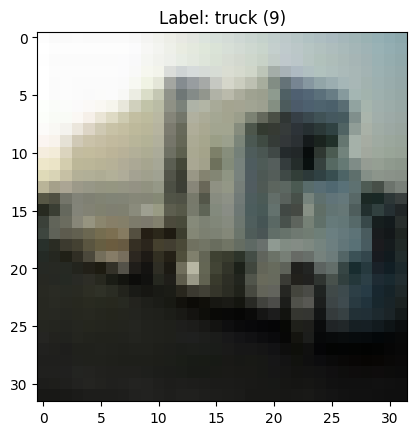

In [174]:
target = random.randint(0, len(data['train']['x']) - 1)
showImg(data['train']['x'][target], title = f"Label: {data['class_names'][data['train']['y'][target]]} ({data['train']['y'][target]})", axis = True)

## Process

Here begins the process which includes data splitting and pre-processing.

### Splitting the Data

In [175]:
# Already splitted...

### Pre-Processing

Image pre-processing, along with some image modification (skew, translate, etc.) are done here.

In [176]:
# Test Data
data['train']['generator'] = (ImageDataGenerator(
	rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)).flow(
	data['train']['x'],
	data['train']['y'],
)

# Validation Data
data['val'] = ImageDataGenerator(
    rescale = 1./255
).flow(
    data['test']['x'],
    data['test']['y'],
)

# Test Data
data['test']['generator'] = (ImageDataGenerator(
    rescale = 1./255,
)).flow(
	data['test']['x'],
	data['test']['y'],
    shuffle = False,
)

### Creating the Model

In [177]:
model = build_resnet18()
model.summary()

Model: "ResNet18_CIFAR10_Functional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_126 (Conv2D)            (None, 32, 32, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_126 (Batch  (None, 32, 32, 32)  128         ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_102 (ReLU)               (None, 32, 32, 32)   0           ['batch

### Compilation and Training

In [178]:
model.compile(
    optimizer = Adam(learning_rate = 1e-4), # 0.0001
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [179]:
batch_size = 64
SPE = len(data['train']['x']) // batch_size
VS = len(data['test']['x']) // batch_size

print(f"Steps per epoch: {SPE}, Validation steps: {VS} (batch size: {batch_size})")

Steps per epoch: 781, Validation steps: 156 (batch size: 64)


Alternative keys could be:

- `recommended`: The default value.
- `current_default`: Uses the CPU count via `multiprocessing.cpu_count()` function.
- `conservative`: The lowest possible.
- `aggressive`: The highest possible.
- `ask`: Prompts which key to use at the end of the run so you can check which you want to use. Must have `verbose` as `True`.

In [180]:
optimal_worker = get_optimal_workers(
    batch_size = batch_size,
    has_augmentation = True,
    verbose = True,
    use = 'aggressive'
)

optimal_worker = int(optimal_worker)
print(f"\nUsing {optimal_worker} workers for training.")

System: 6 physical cores, 12 logical cores, 31.8GB RAM
Recommended workers: 8 (I/O-bound augmentation with medium batches)
Alternatives to test:
  Current default: 12 workers
  Conservative: 5 workers
  Aggressive: 12 workers

Using 12 workers for training.


In [181]:
history = model.fit(
    data["train"]["generator"],
    steps_per_epoch = SPE,
    epochs = 100,
    validation_data = data["val"],
    validation_steps = VS,
    callbacks = callbacks,

    # Multiprocessing settings
    # use_multiprocessing = True,
    workers = optimal_worker,
    max_queue_size = 25,
)

Epoch 1/100
781/781 [==============================] - 50s 60ms/step - loss: 2.1412 - accuracy: 0.2873 - val_loss: 1.6528 - val_accuracy: 0.4087 - lr: 1.0000e-04
Epoch 2/100
781/781 [==============================] - 48s 61ms/step - loss: 1.7059 - accuracy: 0.3952 - val_loss: 1.7558 - val_accuracy: 0.4219 - lr: 1.0000e-04
Epoch 3/100
781/781 [==============================] - 49s 62ms/step - loss: 1.5185 - accuracy: 0.4570 - val_loss: 1.3513 - val_accuracy: 0.5138 - lr: 1.0000e-04
Epoch 4/100
781/781 [==============================] - 49s 62ms/step - loss: 1.3781 - accuracy: 0.5116 - val_loss: 1.2330 - val_accuracy: 0.5781 - lr: 1.0000e-04
Epoch 5/100
781/781 [==============================] - 49s 63ms/step - loss: 1.2665 - accuracy: 0.5523 - val_loss: 1.8348 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 6/100
781/781 [==============================] - 49s 63ms/step - loss: 1.1670 - accuracy: 0.5931 - val_loss: 1.1311 - val_accuracy: 0.6048 - lr: 1.0000e-04
Epoch 7/100
781/781 [=======

## Model Metrics Visualization

In [182]:
_, accuracy = model.evaluate(
    data["test"]["generator"],
    steps = VS,
    verbose = 2
)

156/156 - 3s - loss: 0.3234 - accuracy: 0.9000 - 3s/epoch - 18ms/step


In [183]:
y_pred = model.predict(
    data['test']['generator'],
    steps = VS,
    verbose = 1,
)

y_pred = np.argmax(y_pred, axis = 1)

156/156 [==============================] - 3s 14ms/step


In [184]:
print(len(y_pred))

y_pred.shape

4992


(4992,)

In [185]:
y_true = []
for _ in range(VS):
    _, labels = next(data["test"]["generator"])
    
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

y_true = np.array(y_true)

if len(y_true) != len(y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

print(len(y_true))

y_true.shape

4992


(4992,)

### Accuracy

In [186]:
print(f"Accuracy: {accuracy}")

accuracy *= 100

print(f"Accuracy (Updated): {accuracy:.2f}%")

Accuracy: 0.9000400900840759
Accuracy (Updated): 90.00%


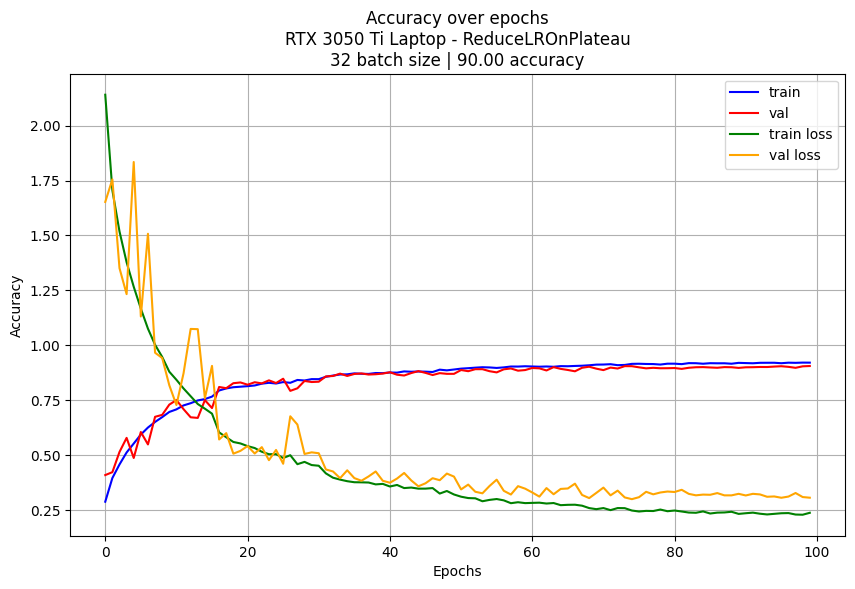

In [187]:
unixTime = int(datetime.datetime.now().timestamp() * 1e6)

plt.figure(figsize = (10, 6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
plt.plot(history.history['loss'], color = 'green', label = 'train loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val loss')
plt.legend()
plt.grid()
plt.title(f'Accuracy over epochs\n{platform} - {lr_strats}\n{data["train"]["generator"].batch_size} batch size | {accuracy:.2f} accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

if not os.path.exists(f"{prefix}/accuracy"):
    os.makedirs(f"{prefix}/accuracy")

if save_plots:
    plt.savefig(f"{prefix}/accuracy/{unixTime}-{accuracy:.2f}%-{file_postfix}.png")

### Confusion Matrix

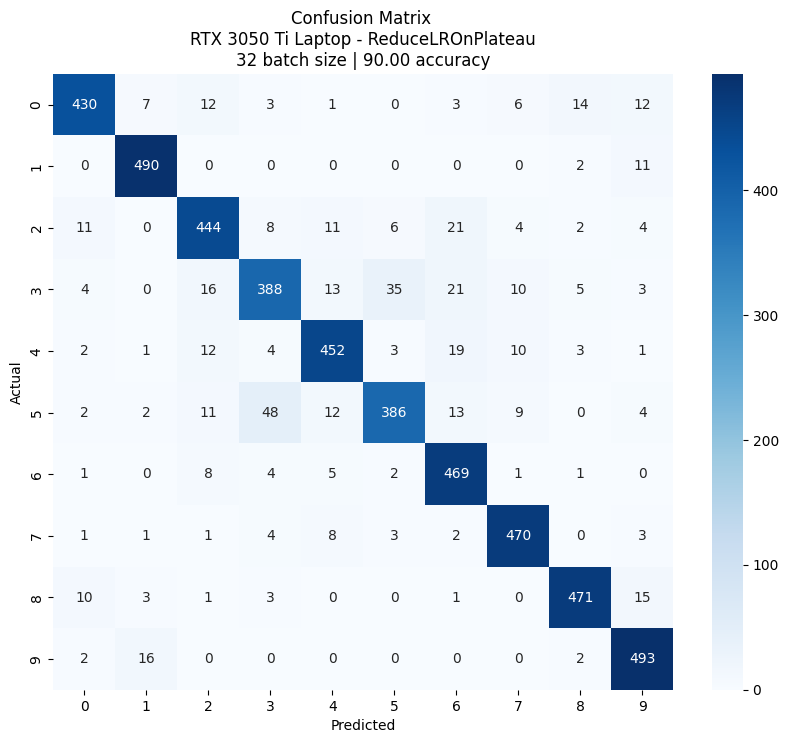

In [188]:
cm = confusion_matrix(
    y_true,
    y_pred
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')

plt.title(f'Confusion Matrix \n{platform} - {lr_strats}\n{data["train"]["generator"].batch_size} batch size | {accuracy:.2f} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

if not os.path.exists(f"{prefix}/confusion_matrix"):
    os.makedirs(f"{prefix}/confusion_matrix")

if save_plots:
    plt.savefig(f"{prefix}/confusion_matrix/{unixTime}-{accuracy:.2f}%-{file_postfix}.png")

## Notification Sound

In [189]:
alarm_iteration = 100
alarm_sound = "notification.wav"
done_sound = "done.wav"

try:
    if os.name == 'nt':
        for i in range(alarm_iteration):
            delay = float("{0:.2f}".format(random.uniform(0, 0.5)))
            
            if os.path.exists(alarm_sound):
                winsound.PlaySound(alarm_sound, winsound.SND_FILENAME)
                time.sleep(delay)
            else:
                winsound.Beep(1000, 500)
                time.sleep(0.5)

            print(f"Alarm sound played {i + 1}/{alarm_iteration} times (delayed by {delay} second{'s' if delay > 0 else ''}).")
            winsound.PlaySound(None, winsound.SND_PURGE)
    else:
        print("Training completed. Beep sound is not available on this OS.")
except KeyboardInterrupt:
    if os.name == 'nt':
        winsound.PlaySound(done_sound, winsound.SND_FILENAME)
        winsound.PlaySound(None, winsound.SND_PURGE)

Alarm sound played 1/100 times (delayed by 0.18 seconds).
Alarm sound played 2/100 times (delayed by 0.27 seconds).
Alarm sound played 3/100 times (delayed by 0.45 seconds).
Alarm sound played 4/100 times (delayed by 0.29 seconds).
Alarm sound played 5/100 times (delayed by 0.08 seconds).
